# Rotating reference frame

As discussed in Viscous flow about a moving body, it is slower
to solve the problem when the body moves in our frame of reference, because
it requires re-generating the grid operations at each time step. However,
when we only have a single rigid body, we can solve the problem in a
frame of reference moving with the body. In this manner, the body
remains invariantly mmersed in the grid, so the problem is faster to solve.

We will demonstrate how to solve a problem in a moving reference frame in this
notebook. First, we need some notation, given by the diagram below:

![comoving-diagram.svg](./assets/comoving-diagram.svg)

The main idea is that we wish to solve the problem in the $(\hat{x},\hat{y})$
reference frame, moving with the body. In that reference frame, the
translational $\mathbf{U}_p$ and rotational $\Omega$ motion of the body appear as effects at infinity.
This is fine for the translational part -- it's equivalent to a freestream velocity.
However, it is problematic for the rotational part in external flows, because the velocity's magnitude grows
with distance from the center of rotation. Instead, we solve for the
velocity expressed relative to the translating frame, but *not the rotating frame*.
However, the components of this velocity are still expressed in the rotating
coordinate system, $\hat{x}$ and $\hat{y}$, which is the key to allowing us
to keep the body fixed in the computational domain.

Mathematically, we write this velocity as $\mathbf{u}' = R^T (\mathbf{u} - \mathbf{U}_p)$.
where $R$ is the rotation operator from the rotating to the inertial coordinate
system. The boundary conditions on $\mathbf{u}'$ are $-R^T \mathbf{U}_p$ at
infinity (a freestream), and $\mathbf{u}' = \Omega \times (\mathbf{x}-\mathbf{X}_p)$
on the surface of the body.

To set the problem up, we simply need to supply the kinematics of the motion,
and to provide an additional argument `reference_body = 1`, which signals
that we wish to solve the problem in a coordinate system moving with body 1.
The default value of this argument is 0, the inertial coordinate system.

Here, we will demonstrate this on a problem involving the flapping of a
flat plate. (This is a simple model for hovering insect flight, if you're
interested!)

In [1]:
using ViscousFlow

In [2]:
using Plots

Let's define a macro that allows us to visualize the kinematics
of the body from the perspective of the inertial reference frame.

In [3]:
macro animate_motion(b,m,dt,tmax,xlim,ylim)
    return esc(quote
            bc = deepcopy($b)
            t0, x0 = 0.0, init_motion_state(bc,$m)
            dxdt = zero(x0)
            x = copy(x0)
            @gif for t in t0:$dt:t0+$tmax
                motion_rhs!(dxdt,x,($m,bc),t)
                global x += dxdt*$dt
                update_body!(bc,x,$m)
                plot(bc,xlims=$xlim,ylims=$ylim)
            end every 5
        end)
end

@animate_motion (macro with 1 method)

Set the Reynolds number

In [4]:
my_params=Dict()
my_params["Re"] = 100

100

Create a domain big enough to hold the vorticity. We will loosen the grid Re a bit.

In [5]:
xlim = (-4.0,4.0)
ylim = (-3.5,2.0)
my_params["grid Re"] = 3.0
g = setup_grid(xlim,ylim,my_params)

PhysicalGrid{2}((270, 192), (135, 121), 0.03, ((-4.02, 4.02), (-3.5999999999999996, 2.1)), 10)

## Create the plate
We create the body as usual. However, in order to facilitate the kinematics
that follow, it is helpful to change the body's intrinsic coordinate system
from its default system -- in which the plate lies along its own x axis
-- to another system in which the plate lies along its y axis. This is
not necessary, but it has some benefits for prescribing the motion and
for visualizing the results.

To make this change of body coordinate system, we use the transform_body!
function. This is different from update_body!, because the latter
only changes the body's placement in the inertial system. To use the
function, we specify a `MotionTransform` with where we want the plate
to lie and at what angle.

In [6]:
Δs = surface_point_spacing(g,my_params)
body = Plate(1.0,Δs)
X = MotionTransform([0,0],π/2)
transform_body!(body,X)

Open polygon with 2 vertices and 24 points
   Current position: (0.0,0.0)
   Current angle (rad): 1.5707963267948966


Plot it, just to check.

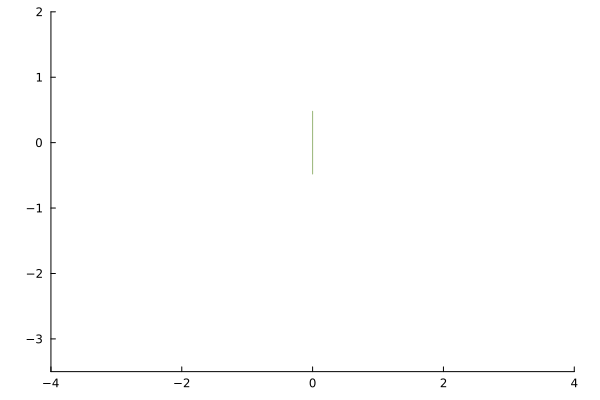

In [7]:
plot(body,xlim=xlim,ylim=ylim)

## Set the kinematics
Here, we will define the kinematics. The wing will pitch about
an axis at its top edge, as in the figure below

![flat-plate-diagram.svg](./assets/flat-plate-diagram.svg)

Thus, $\hat{X}_p = (0,0.5c)$. Since the length of the plate is 1, we are
implicitly scaling the problem by $c$, so we will set this joint at $(0,0.5)$ in
these coordinates.

### The joint placement
We must specify the joint, attaching body 1 (the child) to the inertial system (body 0, the parent). We need
a more detailed form of the `Joint` function now. In this form, we need
to specify how the joint is attached to each body, and how each of its
degrees of freedom move. We will do this piece by piece to explain it.
More details can be found in the documentation for [RigidBodyTools.jl](https://github.com/JuliaIBPM/RigidBodyTools.jl).

To place the joint, we need to specify its position in both the parent's
and the child's coordinate systems. In the parent's system, we can just
place it at the origin, with no rotation. For the child, we place
the joint as desired, at $(0,0.5)$.

In [8]:
parent_body, child_body = 0, 1
Xp = MotionTransform([0,0],0) # transform from inertial system to joint
xpiv = [0.0,0.5]
Xc = MotionTransform(xpiv,0.0)

2d motion transform, x = [0.0, 0.5], R = [1.0 0.0; -0.0 1.0]

### The kinematics
We are creating a joint that has three potential degrees of freedom (angle, x, y),
called a `FreeJoint2d`. However, only the angle and x coordinates of the
joint will be allowed to move. Both of these are assigned oscillatory kinematics.

In [9]:
Ω = π/2 # Flapping angular frequency
Tp = 2π/Ω # Period of flapping
Δα = π/4 # Amplitude of pitching
ϕα = 0 # Pitching phase
adof = OscillatoryDOF(Δα,Ω,ϕα,0.0)

Oscillatory kinematics (amplitude = 0.7853981633974483, ang freq = 1.5707963267948966, phase = 0.0, mean velocity = 0.0)

The motion of the x coordinate

In [10]:
A = 1 # Heaving amplitude
ϕ = -π/2 # Phase lag
xdof = OscillatoryDOF(A,Ω,ϕ,0.0)

ydof = ConstantVelocityDOF(0) # Keep the y coordinate fixed

Constant velocity kinematics (velocity = 0.0)

We put the kinematics into a vector. The degrees of freedom are always ordered `[rotation, x, y]`.

In [11]:
dofs = [adof,xdof,ydof]

3-element Vector{AbstractPrescribedDOFKinematics}:
 Oscillatory kinematics (amplitude = 0.7853981633974483, ang freq = 1.5707963267948966, phase = 0.0, mean velocity = 0.0)
 Oscillatory kinematics (amplitude = 1.0, ang freq = 1.5707963267948966, phase = -1.5707963267948966, mean velocity = 0.0)
 Constant velocity kinematics (velocity = 0.0)

Finally, create the joint and the motion structure.

In [12]:
joint = Joint(FreeJoint2d,parent_body,Xp,child_body,Xc,dofs)
m = RigidBodyMotion(joint,body)

1 linked system(s) of bodies
   1 bodies
   1 joints


Now animate the motion for a complete cycle (4 time units)

[ Info: Saved animation to /var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_fyfulGVwPE.gif


Plots.AnimatedGif("/var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_fyfulGVwPE.gif")
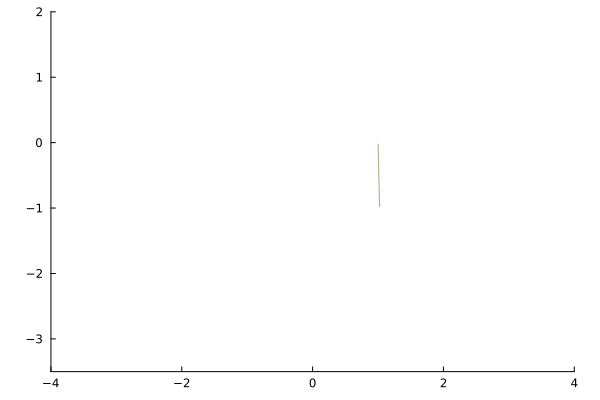

In [13]:
@animate_motion body m Tp/200 Tp xlim ylim

### Boundary condition functions
Instead of using the default boundary condition functions, we define
special ones here that provide the instantaneous surface velocity (i.e. the velocity
of every surface point) from the prescribed
motion. Every surface has an "exterior" and "interior" side. For
a flat plate, these two sides are the upper and lower sides, and both sides
are next to the fluid, so both of them are assigned the prescribed velocity
of the plate. (For closed bodies, we would assign this velocity to only
one of the sides, and zero to the other side. We will see an example of this in a later case.)
We pack these into a special dictionary and pass these to the system construction.


We need to provide specialized boundary conditions for this problem,
and we use the function surface_velocity_in_translating_frame!
for that. Because we are simulating a flat plate, both the positive
and negative sides of the surface must have their boundary velocities
set the same way. If this were instead a closed body, we would set either
the positive or negative side's value to zero.
We pack these into a special dictionary and pass these to the system construction.

In [14]:
function my_vsplus(t,x,base_cache,phys_params,motions)
  vsplus = zeros_surface(base_cache)
  surface_velocity_in_translating_frame!(vsplus,x,base_cache,motions,t)
  return vsplus
end

function my_vsminus(t,x,base_cache,phys_params,motions)
  vsminus = zeros_surface(base_cache)
  surface_velocity_in_translating_frame!(vsminus,x,base_cache,motions,t)
  return vsminus
end

bcdict = Dict("exterior" => my_vsplus, "interior" => my_vsminus)

Dict{String, Function} with 2 entries:
  "interior" => my_vsminus
  "exterior" => my_vsplus

### Construct the system structure
Here, we supply both the motion, the boundary condition functions, and the reference body as additional arguments.

In [15]:
sys = viscousflow_system(g,body,phys_params=my_params,bc=bcdict,motions=m,reference_body=1);

### Set up the initial conditions
This is done the usual way

In [16]:
u0 = init_sol(sys)
tspan = (0.0,10.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 270, ny = 192) cell grid of type Float64 data
  Number of Dual nodes: (nx = 270, ny = 192), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0])

### Solve the problem
Here, we will advance it for one flapping period

In [17]:
step!(integrator,Tp)

### Plot it
Plot the vorticity field

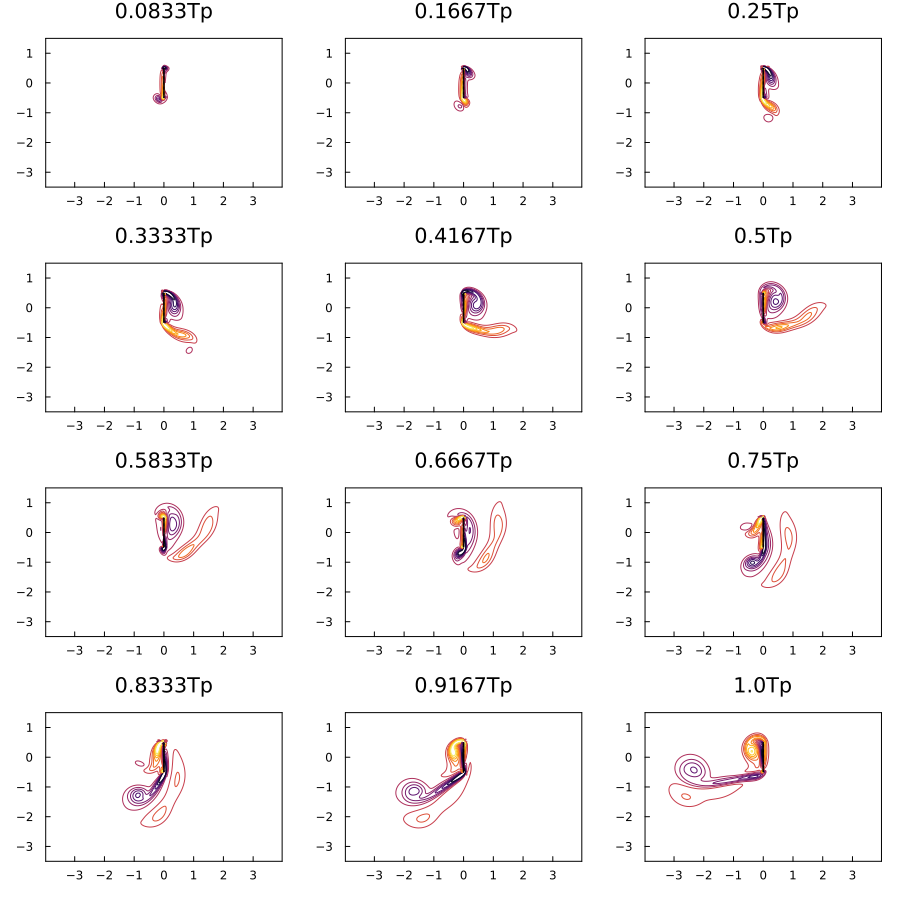

In [18]:
sol = integrator.sol
plt = plot(layout = (4,3), size = (900, 900), legend=:false)
tsnap = Tp/12:Tp/12:Tp
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,clim=(-20,20),levels=range(-20,20,length=16),ylim=(-3.5,1.5),title="$(round(t/Tp,digits=4))Tp")
end
plt

### Plot the forces and moments
The solution is expressed in co-rotating coordinates. To get the force and
moment in inertial coordinates, we
make use of the `axes` keyword, setting it to 0. The moment is computed
about the center of the body's coordinate system, but we can change that behavior
by using the `force_reference` keyword, setting it to 0, for example,
to compute the moment about the origin of the inertial system.

In [19]:
mom, fx, fy = force(sol,sys,1,axes=0);

Plot these

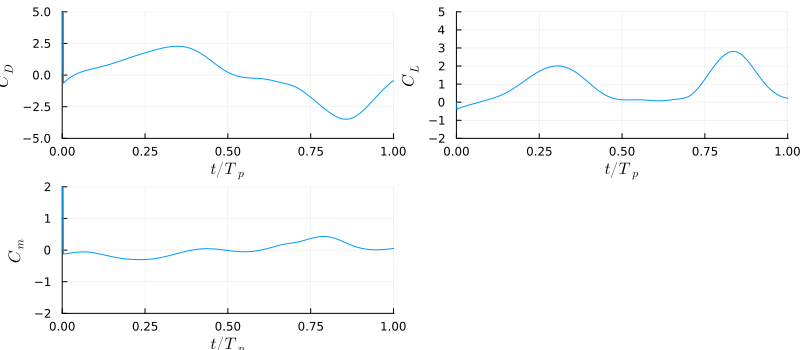

In [20]:
plot(
plot(sol.t/Tp,2*fx/Ω^2,xlim=(0,Inf),ylim=(-5,5),xlabel="\$t/T_p\$",ylabel="\$C_D\$",legend=:false),
plot(sol.t/Tp,2*fy/Ω^2,xlim=(0,Inf),ylim=(-2,5),xlabel="\$t/T_p\$",ylabel="\$C_L\$",legend=:false),
plot(sol.t/Tp,2*mom/Ω^2,xlim=(0,Inf),ylim=(-2,2),xlabel="\$t/T_p\$",ylabel="\$C_m\$",legend=:false),
    size=(800,350)
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*